In [1]:
import math
import os
import re
from typing import List

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from tqdm.notebook import tqdm


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

## load M4 data

In [2]:
df_hourly = pd.read_csv("../m4_data/Hourly-train.csv")
print("hourly read: {}".format(df_hourly.shape))
df_daily = pd.read_csv("../m4_data/Daily-train.csv")
print("daily read: {}".format(df_daily.shape))
df_weekly = pd.read_csv("../m4_data/Weekly-train.csv")
print("weekly: {}".format(df_weekly.shape))
df_monthly = pd.read_csv("../m4_data/Monthly-train.csv")
print("monthly: {}".format(df_monthly.shape))
df_quarterly = pd.read_csv("../m4_data/Quarterly-train.csv")
print("quarterly: {}".format(df_quarterly.shape))
df_yearly = pd.read_csv("../m4_data/Yearly-train.csv")
print("yearly: {}".format(df_yearly.shape))

df_m4_raw = pd.concat([df_hourly,
                   df_daily,
                   df_weekly,
                    df_monthly,
                   df_quarterly,
                   df_yearly])

df_hourly = None
df_daily = None
df_weekly = None
df_monthly = None
df_quarterly = None
df_yearly = None

hourly read: (414, 961)
daily read: (4227, 9920)
weekly: (359, 2598)
monthly: (48000, 2795)
quarterly: (24000, 867)
yearly: (23000, 836)


## load UCR data

In [3]:
ts_train_infos = []
ts_test_infos = []
for root, dirs, files in os.walk("../data/ucr_data/UCRArchive_2018/"):
    for name in files:
        if(name.endswith("_TRAIN.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_train_infos.append((ts_name, os.path.join(root,name)))
        elif(name.endswith("_TEST.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_test_infos.append((ts_name, os.path.join(root,name)))

In [4]:
df_ucr_train = pd.DataFrame()
df_ucr_test = pd.DataFrame()

for ts_info in tqdm(ts_train_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_ucr_train = df_ucr_train.append(df_tmp)
    
# for ts_info in tqdm(ts_test_infos):
#     ts_name = ts_info[0]
#     fp = ts_info[1]
    
#     df_tmp = pd.read_csv(fp, sep='\t', header=None)
#     df_tmp['name'] = ts_name
#     df_tmp['no'] = df_tmp.index
#     cols = df_tmp.columns.tolist()
#     cols = cols[-2:] + cols[:-2]
#     df_tmp = df_tmp[cols]
#     df_ucr_test = df_ucr_test.append(df_tmp)
    

print("df_train shape: {}".format(df_ucr_train.shape))
# print("df_test shape: {}".format(df_ucr_test.shape))

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

df_train shape: (64306, 2847)
df_test shape: (136855, 2847)


## Fourier transform

In [34]:
def get_top_k_freq(PSD: np.array, k: int)->List[int]:
    """ return top k indexes with largest PSD val"""
    PSD = [np.real(val) for val in PSD]
    return sorted(range(len(PSD)), key= lambda x: PSD[x])[-k:]
    

In [44]:
def get_freq_m4(s: pd.Series, k:int=5) -> List[float]:
    """ compute frequencies for M4 pandas series"""
    df = pd.DataFrame()
    f=np.array(s.iloc[1:].dropna())
    n = f.size
    wdw = np.hamming(n)
    freq = np.arange(n)/n

    # FFT
    fhat = np.fft.fft(f)
    PSD = np.real(fhat * np.conj(fhat) / n)
    top_fft_idx = get_top_k_freq(PSD,k)
    fft_freq = freq[top_fft_idx]
    df_tmp = pd.DataFrame(fft_freq, columns=['val'])
    df_tmp['type']='FFT'
    df = df.append(df_tmp)
    # Hamming
    fhat = np.fft.fft(f*wdw)
    PSD = np.real(fhat * np.conj(fhat) / n)
    freq = np.arange(n)/f.size
    top_ham_idx = get_top_k_freq(PSD,k)
    ham_freq = freq[top_ham_idx]
    df_tmp = pd.DataFrame(ham_freq, columns=['val'])
    df_tmp['type']='Hamming'
    df = df.append(df_tmp)
    # Welch
    seg_length = np.floor(1/20*n)
    if seg_length == 0:
        seg_length=10
    welch_freqs, PSD_welch = signal.welch(f, nperseg=seg_length,
                                      window='hamming')
    top_ham_idx = get_top_k_freq(PSD_welch,k)
    welch_freq = freq[top_ham_idx]
    df_tmp = pd.DataFrame(welch_freq, columns=['val'])
    df_tmp['type']='Welch'
    df = df.append(df_tmp)
    
    return df


In [54]:
def get_freq_ucr(s: pd.Series, k:int=5) -> List[float]:
    """ compute frequencies for M4 pandas series"""
    df = pd.DataFrame()
    f=np.array(s.iloc[3:].dropna())
    n = f.size
    wdw = np.hamming(n)
    freq = np.arange(n)/n

    # FFT
    fhat = np.fft.fft(f)
    PSD = np.real(fhat * np.conj(fhat) / n)
    top_fft_idx = get_top_k_freq(PSD,k)
    fft_freq = freq[top_fft_idx]
    df_tmp = pd.DataFrame(fft_freq, columns=['val'])
    df_tmp['type']='FFT'
    df = df.append(df_tmp)
    # Hamming
    fhat = np.fft.fft(f*wdw)
    PSD = np.real(fhat * np.conj(fhat) / n)
    freq = np.arange(n)/f.size
    top_ham_idx = get_top_k_freq(PSD,k)
    ham_freq = freq[top_ham_idx]
    df_tmp = pd.DataFrame(ham_freq, columns=['val'])
    df_tmp['type']='Hamming'
    df = df.append(df_tmp)
    # Welch
    seg_length = np.floor(1/20*n)
    if seg_length == 0:
        seg_length=10
    welch_freqs, PSD_welch = signal.welch(f, nperseg=seg_length,
                                      window='hamming')
    top_ham_idx = get_top_k_freq(PSD_welch,k)
    welch_freq = freq[top_ham_idx]
    df_tmp = pd.DataFrame(welch_freq, columns=['val'])
    df_tmp['type']='Welch'
    df = df.append(df_tmp)
    return df

create df transpose for faster computation

In [56]:
tqdm.pandas()
res = df_m4_raw.progress_apply(func=get_freq_m4, axis=1)
df_m4_res = pd.concat(list(res))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [60]:
df_m4_res.to_csv("../data/data_expl_m4_freqs.csv", index=True)

In [58]:
res = df_ucr_train.progress_apply(func=get_freq_ucr, axis=1)
df_ucr_res = pd.concat(list(res))

  0%|          | 0/64306 [00:00<?, ?it/s]

/Users/philipp/anaconda3/envs/unic2/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 10 is greater than input length  = 8, using nperseg = 8
  warnings.warn('nperseg = {0:d} is greater than input length '


In [59]:
df_ucr_res.to_csv("../data/data_expl_ucr_freqs.csv", index=True)

In [63]:
df_ucr_res['type'].unique()

array(['FFT', 'Hamming', 'Welch'], dtype=object)

In [66]:
def convert_series(s: pd.Series,col_name)->pd.DataFrame:
    """convert list to common series"""
    df = pd.DataFrame(s, columns=['value'])
    df['k'] = col_name

In [99]:
cols = list(df_m4_f)

df_m4_top_f = pd.DataFrame(columns=['k','val'])
df_ucr_top_f = pd.DataFrame(columns=['k','val'])
for col in tqdm(cols):
    
    df_tmp_m4 = pd.DataFrame(df_m4_f[col])
    df_tmp_m4['k'] = col
    df_tmp_m4.columns = ['val','k']
    df_m4_top_f = df_m4_top_f.append(df_tmp_m4, ignore_index=True)
    
    df_tmp_ucr = pd.DataFrame(df_ucr_f[col])
    df_tmp_ucr['k'] = col
    df_tmp_ucr.columns = ['val','k']
    df_ucr_top_f = df_ucr_top_f.append(df_tmp_ucr, ignore_index=True)
    
    
df_ucr_top_f.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,k,val
0,0,0.997253
1,0,0.002747
2,0,0.997253
3,0,0.997253
4,0,0.002747


### Create FFT Histogram

In [9]:
df_m4_hist = pd.read_csv("../data/data_expl_m4_freqs.csv")
df_m4_hist.columns = ['idx_pos','val','type']
df_m4_hist = df_m4_hist[['idx_pos','type', 'val']]
df_ucr_hist = pd.read_csv("../data/data_expl_ucr_freqs.csv")
df_ucr_hist.columns = ['idx_pos','val','type']
df_ucr_hist = df_ucr_hist[['idx_pos','type', 'val']]

In [15]:
df_ucr_hist.describe()

,idx_pos,val
count,894516.000000,894516.000000
mean,1.903999,0.356527
std,1.405817,0.452043
min,0.000000,0.000000
25%,1.000000,0.004000
50%,2.000000,0.023438
75%,3.000000,0.962000
max,4.000000,0.999648


In [29]:
# M4 bin width
cnt = df_m4_hist.describe().loc["count",'val']
q75 = df_m4_hist.describe().loc["75%",'val']
q25 = df_m4_hist.describe().loc["25%",'val']
max_val = df_m4_hist['val'].max()
min_val = df_m4_hist['val'].min()
# Freedman–Diaconis rule
h = 2 * (q75-q25)*cnt**(-1./3)
b_m4 = int((max_val-min_val)/h)
# UCR bin width
cnt = df_ucr_hist.describe().loc["count",'val']
q75 = df_ucr_hist.describe().loc["75%",'val']
q25 = df_ucr_hist.describe().loc["25%",'val']
max_val = df_ucr_hist['val'].max()
min_val = df_ucr_hist['val'].min()
# Freedman–Diaconis rule
h = 2 * (q75-q25)*cnt**(-1./3)
b_ucr = int((max_val-min_val)/h)


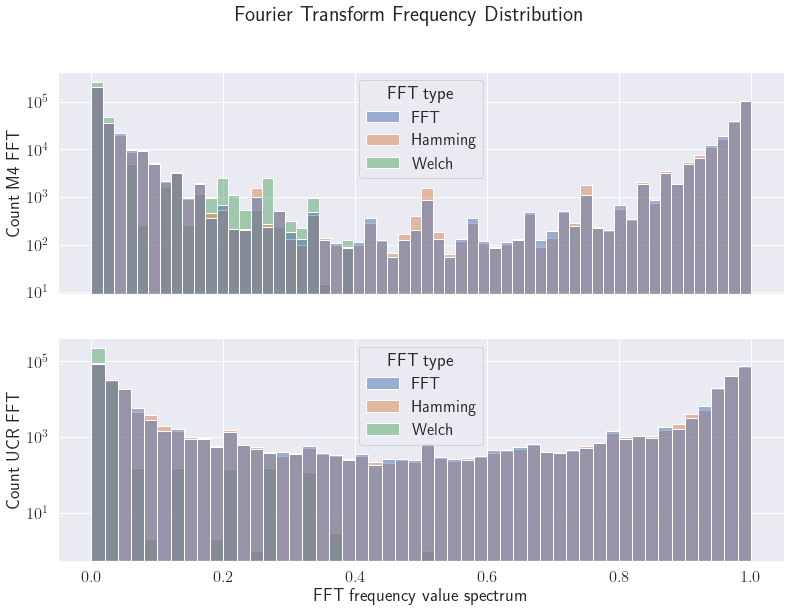

In [50]:
sns.set(font_scale=1.5)

fig, axs = plt.subplots(2, 1, figsize=(13,9), sharex=True)
# fig.tight_layout()
fig.suptitle("Fourier Transform Frequency Distribution")

sns.histplot(data=df_m4_hist, x='val', hue='type',
             bins=b_m4, ax=axs.flatten()[0]);
axs.flatten()[0].set_yscale('log')
axs.flatten()[0].set_ylabel(" Count M4 FFT")
leg = axs.flatten()[0].get_legend()
leg.set_title("FFT type");

sns.histplot(data=df_ucr_hist, x='val', hue='type',
             bins=b_ucr, ax=axs.flatten()[1]);
axs.flatten()[1].set_xlabel("FFT frequency value spectrum")
axs.flatten()[1].set_yscale('log')
axs.flatten()[1].set_ylabel("Count UCR FFT")
leg = axs.flatten()[1].get_legend()
leg.set_title("FFT type");
fig.savefig("../img/fft_freq_dist_ucr_m4.png")

In [58]:
topks = df_ucr_hist['idx_pos'].unique()[-1::-1] ### reverse order with most import frequency at the top
topks

array([4, 3, 2, 1, 0])

In [113]:
def compute_bins(df: pd.DataFrame)-> int:
    """ compute no. of bins viaFreedman–Diaconis rule"""
    cnt = df.describe().loc["count",'val']
    q75 = df.describe().loc["75%",'val']
    q25 = df.describe().loc["25%",'val']
    max_val = df['val'].max()
    min_val = df['val'].min()
    # Freedman–Diaconis rule
    h = 2 * (q75-q25)*cnt**(-1./3)
    if int(h) == 0:
        h =3
    b = int((max_val-min_val)/h)
#     print("b is {}".format(b))
    if int(b)==0:
        b=3
    return b

top: 1 - (242043, 3)
unique: 1186 - range: 0.3333333333333333
top: 2 - (247188, 3)
unique: 4034 - range: 0.999899183385422
top: 3 - (260103, 3)
unique: 4091 - range: 0.999899183385422
top: 4 - (285964, 3)
unique: 6400 - range: 0.9998724815098188
top: 5 - (300000, 3)
unique: 6518 - range: 0.9997804610318332


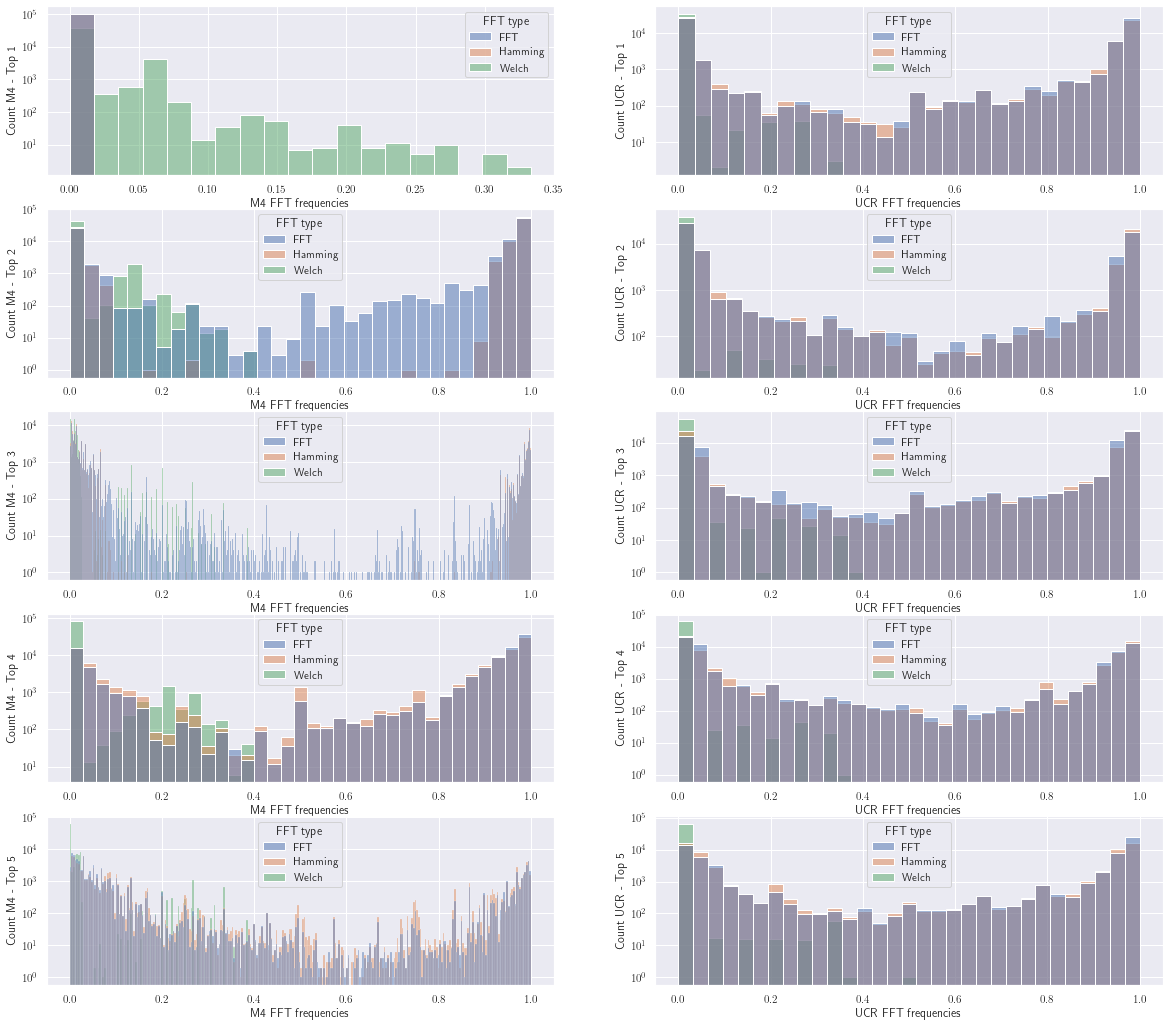

In [123]:
sns.set(font_scale=1)
fig, axs = plt.subplots(topks.size, 2, figsize=(20,18))
#fig.tight_layout()
#fig.suptitle("Fourier Transform Frequency Distribution by top k")

for i in range(topks.size):
    topk = topks[i]
    df_m4_tmp = df_m4_hist[df_m4_hist['idx_pos']==topk]
    rnge = df_m4_tmp['val'].max() - df_m4_tmp['val'].min()
    print("top: {} - {}\nunique: {} - range: {}".format(i+1,df_m4_tmp.shape, df_m4_tmp['val'].nunique(), rnge))
    b_m4 = compute_bins(df_m4_tmp)
    df_ucr_tmp = df_ucr_hist[df_ucr_hist['idx_pos']==topk]
    b_ucr = compute_bins(df_ucr_tmp)
    
    sns.histplot(data=df_m4_tmp, x='val', hue='type',
                 bins='auto', ax=axs[i,0]);
    axs[i,0].set_xlabel("M4 FFT frequencies")
    axs[i,0].set_yscale('log')
    axs[i,0].set_ylabel(" Count M4 - Top {}".format(i+1))
    leg = axs[i,0].get_legend()
    leg.set_title("FFT type");

    sns.histplot(data=df_ucr_tmp, x='val', hue='type', bins='fd',
                ax=axs[i,1]);
    axs[i,1].set_xlabel("UCR FFT frequencies")
    axs[i,1].set_yscale('log')
    axs[i,1].set_ylabel("Count UCR - Top {}".format(i+1))
    leg = axs[i,1].get_legend()
    leg.set_title("FFT type");

fig.savefig("../img/fft_freq_topk.png")